# Detecting Issues in an Image Dataset with Datalab

This quickstart tutorial demonstrates how to find issues in image classification data. Here we use the Fashion-MNIST dataset (60,000 images of fashion products from 10 categories), but you can replace this with your own image classification dataset and still follow the same tutorial.

**Overview of what we'll do in this tutorial:**

- Build a simple [PyTorch](https://pytorch.org/) neural net.

- Use cross-validation to compute out-of-sample predicted probabilities (`pred_probs`) and feature embeddings (`features`) for each image in the dataset.

- Utilize these `pred_probs` and `features` to identify potential issues within the dataset using the `Datalab` class from cleanlab. The issues found by cleanlab include mislabeled examples, near duplicates, outliers, and image-specific problems such as excessively dark or low information images.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have a ML model? Run cross-validation to get out-of-sample `pred_probs` and provide `features` (embeddings of the data). Then use the code below to find any potential issues in your dataset (you can also run this code with one of `pred_probs` or `features` instead of both, but less issue types will be considered).


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")  # include `image_key` to detect low-quality images
lab.find_issues(pred_probs=pred_probs, features=features)

lab.report()
```
    
</div>
</div>

## 1. Install and import required dependencies

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib torch torchvision datasets>=2.19.0
!pip install "cleanlab[image]"
# We install cleanlab with extra dependencies for image data
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install "cleanlab[image] @ git+https://github.com/cleanlab/cleanlab.git"
```

In [1]:
# Package installation (this cell is hidden from docs.cleanlab.ai).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "datasets", "cleanvision"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install "cleanlab[image]"  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

# Suppress benign warnings: 
import warnings 
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [2]:
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
import math
import time
import multiprocessing

from cleanlab import Datalab
from datasets import load_dataset

## 2. Fetch and normalize the Fashion-MNIST dataset

Load train split of  the fashion_mnist dataset and view the number of rows and columns in the dataset

In [3]:
dataset = load_dataset("fashion_mnist", split="train")
dataset

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

Get number of classes in the dataset

In [4]:
num_classes = len(dataset.features["label"].names)
num_classes

10

In [5]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")


# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0)  # each pixel value was originally between 0 and 255 
    return example


transformed_dataset = transformed_dataset.map(normalize, num_proc=multiprocessing.cpu_count())

Map (num_proc=4):   0%|          | 0/60000 [00:00<?, ? examples/s]

Convert the transformed dataset to a torch dataset. Torch datasets are more efficient with dataloading in practice.

In [6]:
torch_dataset = TensorDataset(transformed_dataset["image"], transformed_dataset["label"])

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Load any huggingface dataset or your local image folder dataset, apply relevant transformations, and continue with the rest of the tutorial.

</div>

## 3. Define a classification model
Here, we define a simple neural network with PyTorch. Note this is just a toy model to ensure quick runtimes for the tutorial, you can replace it with any other (larger) PyTorch network.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.linear = nn.Sequential(nn.LazyLinear(128), nn.ReLU())
        self.output = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.embeddings(x)
        x = self.output(x)
        return x

    def embeddings(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.linear(x)
        return x

In [8]:
# This (optional) cell is hidden from docs.cleanlab.ai

SEED = 123  # for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(SEED)

<details><summary>Helper methods for cross validation **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data["image"].to(device), data["label"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)
```
</details>

In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # run the model on the test set to predict labels
            outputs = net(images)

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Method for training the model
def train(trainloader, testloader, n_epochs, patience):
    model = Net()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters())

    model = model.to(device)

    best_test_accuracy = 0.0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start_epoch = time.time()
        running_loss = 0.0

        for _, data in enumerate(trainloader):
            # get the inputs; data is a dict of {"image": images, "label": labels}

            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.detach().cpu().item()

        # Get accuracy on the test set
        accuracy = get_test_accuracy(model, testloader)

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        # Condition for early stopping
        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        end_epoch = time.time()

        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy:.3f} time_taken: {end_epoch - start_epoch:.3f}"
        )
    return model


# Method for computing out-of-sample embeddings
def compute_embeddings(model, testloader):
    embeddings_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            embeddings = model.embeddings(images)
            embeddings_list.append(embeddings.cpu())

    return torch.vstack(embeddings_list)


# Method for computing out-of-sample predicted probabilities
def compute_pred_probs(model, testloader):
    pred_probs_list = []

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)
            pred_probs_list.append(outputs.cpu())

    return torch.vstack(pred_probs_list)

## 4. Prepare the dataset for K-fold cross-validation 

To find label issues based on `pred_probs`, we recommend out-of-sample predictions, which can be produced [via K-fold cross-validation](https://docs.cleanlab.ai/stable/tutorials/pred_probs_cross_val.html). To ensure this tutorial runs quickly, we set K and other important neural network training hyperparameters to small values here. Use larger values to get good results in practice!

In [10]:
K = 3  # Number of cross-validation folds. Set to small value here to ensure quick runtimes, we recommend 5 or 10 in practice for more accurate estimates.
n_epochs = 2  # Number of epochs to train model for. Set to a small value here for quick runtime, you should use a larger value in practice.
patience = 2  # Parameter for early stopping. If the validation accuracy does not improve for this many epochs, training will stop.
train_batch_size = 64  # Batch size for training
test_batch_size = 512  # Batch size for testing
num_workers = multiprocessing.cpu_count()  # Number of workers for data loaders

# Create k splits of the dataset
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
splits = kfold.split(transformed_dataset, transformed_dataset["label"])

train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

## 5. Compute out-of-sample predicted probabilities and feature embeddings

We use cross-validation to compute out-of-sample predicted probabilities separately for each dataset fold. However, we use only one model to generate embeddings for all the images across the full dataset. This ensures all feature embeddings lie in the same representation space for more accurate detection of data issues. Here we embed all the data using our model trained in the first cross-validation fold, but you could also train a separate embedding model on the full dataset.

In [11]:
pred_probs_list, embeddings_list = [], []
embeddings_model = None

for i in range(K):
    print(f"\nTraining on fold: {i+1} ...")

    # Create train and test sets and corresponding dataloaders
    trainset = Subset(torch_dataset, train_id_list[i])
    testset = Subset(torch_dataset, test_id_list[i])

    trainloader = DataLoader(
        trainset,
        batch_size=train_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    testloader = DataLoader(
        testset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )

    # Train model
    model = train(trainloader, testloader, n_epochs, patience)
    if embeddings_model is None:
        embeddings_model = model

    # Compute out-of-sample embeddings
    print("Computing feature embeddings ...")
    fold_embeddings = compute_embeddings(embeddings_model, testloader)
    embeddings_list.append(fold_embeddings)

    print("Computing predicted probabilities ...")
    # Compute out-of-sample predicted probabilities
    fold_pred_probs = compute_pred_probs(model, testloader)
    pred_probs_list.append(fold_pred_probs)

print("Finished Training")


# Combine embeddings and predicted probabilities from each fold
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()


Training on fold: 1 ...


epoch: 1 loss: 0.483 test acc: 86.905 time_taken: 4.928


epoch: 2 loss: 0.330 test acc: 88.090 time_taken: 4.643
Computing feature embeddings ...


  0%|          | 0/40 [00:00<?, ?it/s]

Computing predicted probabilities ...


  0%|          | 0/40 [00:00<?, ?it/s]


Training on fold: 2 ...


epoch: 1 loss: 0.492 test acc: 87.385 time_taken: 4.949


epoch: 2 loss: 0.330 test acc: 88.550 time_taken: 4.546
Computing feature embeddings ...


  0%|          | 0/40 [00:00<?, ?it/s]

Computing predicted probabilities ...


  0%|          | 0/40 [00:00<?, ?it/s]


Training on fold: 3 ...


epoch: 1 loss: 0.476 test acc: 86.510 time_taken: 4.908


epoch: 2 loss: 0.326 test acc: 86.660 time_taken: 4.541
Computing feature embeddings ...


  0%|          | 0/40 [00:00<?, ?it/s]

Computing predicted probabilities ...


  0%|          | 0/40 [00:00<?, ?it/s]

Finished Training


Reorder rows of the dataset based on row order in `features` and `pred_probs`. **Carefully ensure your ordering of the dataset matches these objects!**
Make sure that the columns of your `pred_probs` are properly ordered with respect to the ordering of classes, which for Datalab is: lexicographically sorted by class name.

In [12]:
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

## 7. Use cleanlab to find issues

Based on the out-of-sample predicted probabilities and feature embeddings from our ML model, cleanlab can automatically detect issues in our labeled dataset. 

Here we use cleanlab's `Datalab` class to find issues in our data. `Datalab` supports several data formats, in this tutorial we have a Hugging Face Dataset. `Datalab` takes in two optional dataset arguments:  `label_name`, which corresponds to the column containing labels (if your dataset is labeled), and `image_key`, corresponding to the name of a key in your vision dataset to access the raw images. When you provide these optional arguments, `Datalab` will audit your dataset for more types of issues than it would by default.

In [13]:
lab = Datalab(data=dataset, label_name="label", image_key="image")

The `find_issues` method can automatically infer the types of issues to be checked for based on the provided arguments. Here, we provide `features` and `pred_probs` as arguments. If you want to check for a specific issue type, you can do so using the `issue_types` argument. Check the [documentation](https://docs.cleanlab.ai/stable/cleanlab/datalab/datalab.html#cleanlab.datalab.datalab.Datalab.find_issues) for a more comprehensive guide on `find_issues` method.

In [14]:
lab.find_issues(features=features, pred_probs=pred_probs)

Finding null issues ...
Finding label issues ...


Finding outlier issues ...


Finding near_duplicate issues ...
Finding non_iid issues ...


Finding class_imbalance issues ...
Finding underperforming_group issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


Computing scores:   0%|          | 0/60000 [00:00<?, ?it/s]

Removing grayscale from potential issues in the dataset as it exceeds max_prevalence=0.1
Finding spurious correlation issues in the dataset ...



Audit complete. 7530 issues found in the dataset.


### View report

After the audit is complete, we can view a high-level report of detected data issues.

Dataset Information: num_examples: 60000, num_classes: 10

Here is a summary of various issues found in your data:

     issue_type  num_issues
        outlier        3662
          label        3435
 near_duplicate         251
low_information         166
           dark          16

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


---------------------- outlier issues ----------------------

About this issue:
	Examples that are very different from the rest of the dataset
    (i.e. potentially out-of-distribution or rare/anomalous instances).
    

Number of examples with this issue: 3662
Overall dataset quality in terms of this issue: 0.3690

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
40378              Tr

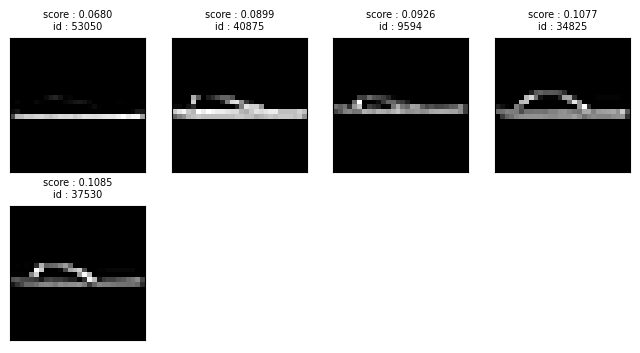

----------------------- dark images ------------------------

Number of examples with this issue: 16
Examples representing most severe instances of this issue:



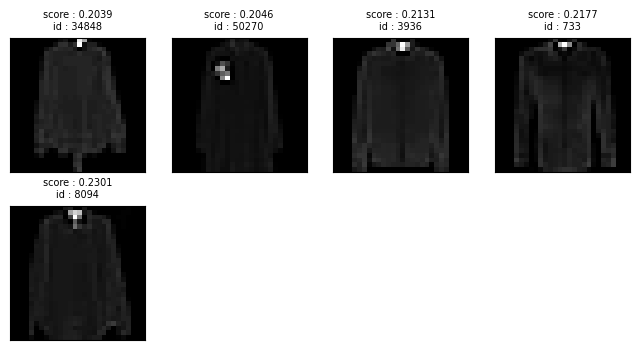

In [15]:
lab.report()

### Label issues

Let's first inspect mislabeled examples in the dataset. Such errors occur when the given label for an image is incorrect, usually due to mistakes made by data annotators. Cleanlab automatically detects mislabeled data that you can correct to improve your dataset.

For each type of issue that Cleanlab detects, you can use the `get_issues` method to see which examples in the dataset exhibit this type of issue (and how severely). Let's see which images in our dataset are estimated to be mislabeled:

In [16]:
label_issues = lab.get_issues("label")
label_issues.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.174403,T - shirt / top,Dress
1,False,0.982475,T - shirt / top,T - shirt / top
2,False,0.994125,Sandal,Sandal
3,False,0.920702,Sandal,Sandal
4,False,0.999330,Dress,Dress


The above dataframe contains a `label_score` for each example in the dataset. These numeric quality scores lie between 0 and 1, where lower scores indicate examples more likely to be mislabeled. It contains a boolean column `is_label_issue` specifying whether or not each example appears to have a label issue (indicating it is likely mislabeled).

Filter the `label_issues` DataFrame to see which examples have label issues, and sort by `label_score`(in ascending order) to see the most likely mislabeled examples first.

In [17]:
label_issues_df = label_issues.query("is_label_issue").sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
11262,True,0.000013,Coat,T - shirt / top
53564,True,0.000018,Pullover,T - shirt / top
54078,True,0.000022,Pullover,Dress
19228,True,0.000040,Dress,Shirt
35027,True,0.000054,Ankle boot,Bag


<details><summary>We define a helper method plot_label_issue_examples to visualize results. **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()
```
</details>

In [18]:
def plot_label_issue_examples(label_issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    label_issue_indices = label_issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(label_issue_indices[i])
        row = label_issues.loc[idx]
        ax.set_title(
            f"id: {idx}\n GL: {row.given_label}\n SL: {row.predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

#### View most likely examples with label errors

Here we define
`GL` : given label in the original dataset
`SL` : suggested alternative label by cleanlab

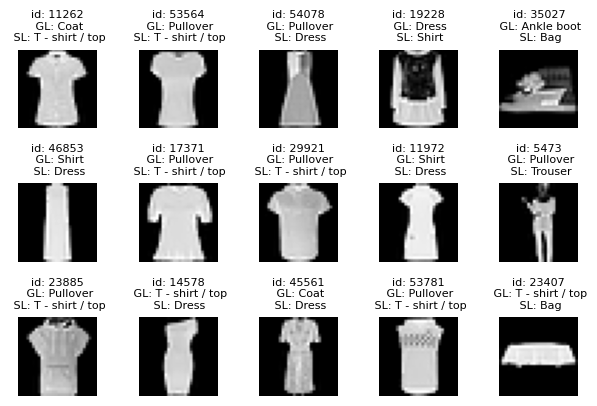

In [19]:
plot_label_issue_examples(label_issues_df, num_examples=15)

### Outlier issues

Datalab also detects atypical images lurking in our dataset. Such outliers are significantly different from the majority of the dataset and may have an outsized impact on how models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score, where examples with the lowest scores are those that appear least typical relative to the rest of the dataset.

In [20]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df.query("is_outlier_issue").sort_values("outlier_score")
outlier_issues_df.head()

,is_outlier_issue,outlier_score
40378,True,6.412596e-07
27080,True,1.873981e-06
34822,True,1.959040e-06
25316,True,2.245950e-06
2090,True,3.913310e-06


#### View most severe outliers

In this visualization, the first image in every row shows the potential outlier, while the remaining images in the same row depict typical instances from the corresponding class.

<details><summary>We define a helper method plot_outlier_issues_examples to visualize results. **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    images_to_plot = []
    labels = []
    idlist = []
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        labels.append(label)
        idlist.append(idx)
        images_to_plot.append(image)
        images_to_plot.extend(comparison_images)
        count += 1
        if count >= nrows:
            break

    ncols = 1 + N_comparison_images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    for i, ax in enumerate(axes_list):
        if i % ncols == 0:
            ax.set_title(f"id: {idlist[i // ncols]}\n GL: {labels[i // ncols]}", fontdict={"fontsize": 8})
        ax.imshow(images_to_plot[i], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()
```
</details>

In [21]:
def plot_outlier_issues_examples(outlier_issues_df, num_examples):
    ncols = 4
    nrows = num_examples
    N_comparison_images = ncols - 1

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    count = 0
    images_to_plot = []
    labels = []
    idlist = []
    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        labels.append(label)
        idlist.append(idx)
        images_to_plot.append(image)
        images_to_plot.extend(comparison_images)
        count += 1
        if count >= nrows:
            break

    ncols = 1 + N_comparison_images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    for i, ax in enumerate(axes_list):
        if i % ncols == 0:
            ax.set_title(
                f"id: {idlist[i // ncols]}\n GL: {labels[i // ncols]}", fontdict={"fontsize": 8}
            )
        ax.imshow(images_to_plot[i], cmap="gray")
        ax.axis("off")
    plt.subplots_adjust(hspace=0.7)
    plt.show()

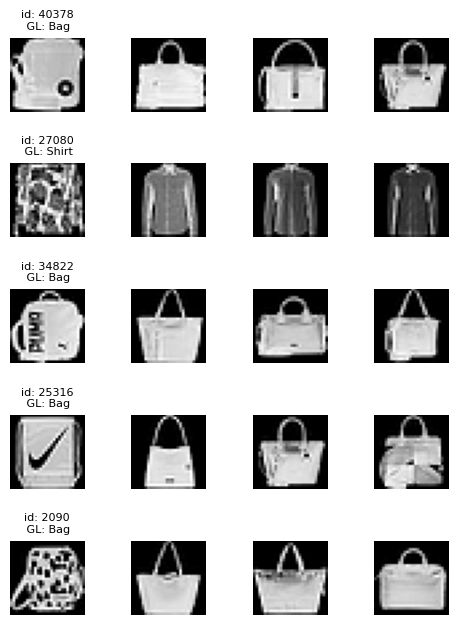

In [22]:
plot_outlier_issues_examples(outlier_issues_df, num_examples=5)

### Near duplicate issues

Datalab also detects which examples are (near) duplicates of other examples in the dataset. Near duplicate images in a dataset can lead to model overfitting and have an outsized impact on evaluation metrics (especially when you have duplicates between training and test splits).

The `near_duplicate_issues` DataFrame tells us which examples are considered to be nearly duplicated in the dataset (including exact duplicates as well). We can sort all images via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe instances of a type of issue, in this case, how similar the image is to its closest neighbor in the dataset).

This allows us to visualize examples in the dataset that are considered nearly duplicated, along with their highly similar counterparts.

In [23]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score"
)
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
9762,True,0.000807,"[258, 54565, 47139]",0.000015
258,True,0.000807,"[9762, 54565, 47139]",0.000015
30968,True,0.001271,[30659],0.000024
30659,True,0.001271,[30968],0.000024
54565,True,0.001306,"[9762, 258, 47139]",0.000024


#### View sets of near duplicate images

<details><summary>We define a helper method plot_near_duplicate_issue_examples to visualize results. **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()
```
</details>

In [24]:
def plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=3):
    nrows = num_examples
    seen_id_pairs = set()

    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    count = 0
    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)
        count += 1
        if count >= nrows:
            break

    plt.show()

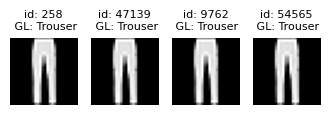

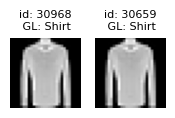

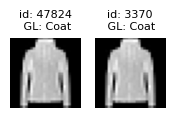

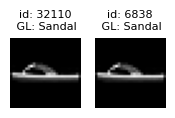

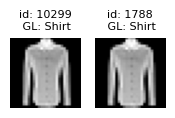

In [25]:
plot_near_duplicate_issue_examples(near_duplicate_issues_df, num_examples=5)

Learn more about handling near duplicates detected in a dataset from [the FAQ](../faq.html#How-to-handle-near-duplicate-data-identified-by-cleanlab?).

### Dark images

Datalab can also detect low-quality images in the dataset, such as those that are abnormally dark. It can be challenging for both annotators and models to assign a proper class label for low-quality data, which can hamper model training and testing.

The `dark_issues` DataFrame reveals which examples are considered to be abnormally dark. We can sort them via the `dark_score` which quantifies how severe this issue is for each image (lower values indicate more severe instances of a type of issue). This allows us to visualize images in the dataset considered to be too dark (you might consider omitting such low-quality examples from a training dataset).

In [26]:
dark_issues = lab.get_issues("dark")
dark_issues_df = dark_issues.query("is_dark_issue").sort_values("dark_score")
dark_issues_df.head()

,is_dark_issue,dark_score
34848,True,0.203922
50270,True,0.204588
3936,True,0.213098
733,True,0.217686
8094,True,0.230118


#### View top examples of dark images

<details><summary>We define a helper method plot_image_issue_examples to visualize results. **(click to expand)**</summary>

```python
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

def plot_image_issue_examples(issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(hspace=0.7)
    plt.show()
```
</details>

In [27]:
def plot_image_issue_examples(issues_df, num_examples=15):
    ncols = 5
    nrows = int(math.ceil(num_examples / ncols))

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows))
    axes_list = axes.flatten()
    issue_indices = issues_df.index.values

    for i, ax in enumerate(axes_list):
        if i >= num_examples:
            ax.axis("off")
            continue
        idx = int(issue_indices[i])
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        ax.set_title(
            f"id: {idx}\n GL: {label}\n SL: {predicted_label}",
            fontdict={"fontsize": 8},
        )
        ax.imshow(dataset[idx]["image"], cmap="gray")
        ax.axis("off")

    plt.subplots_adjust(hspace=0.7)
    plt.show()

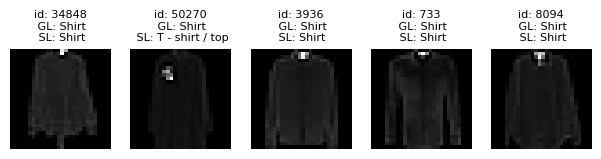

In [28]:
plot_image_issue_examples(dark_issues_df, num_examples=5)

We can see from above examples that too dark images can also lead to label errors as it is difficult to see the contents of the image clearly.

### Low information images

Other types of low-quality images that Datalab can automatically detect include images whose information content is low. Low information images can hamper model generalization if they are present disproportionately in some classes.

The `lowinfo_issues` DataFrame reveals which images are considered to be low information. We can sort them via the `low_information_score` which quantifies how severe this issue is for each image (lower values indicate more severe instances of a type of issue). This allows us to visualize the images in our dataset containing the least amount of information (you might consider omitting such low-quality examples from a training dataset).

In [29]:
lowinfo_issues = lab.get_issues("low_information")
lowinfo_issues_df = lowinfo_issues.query("is_low_information_issue").sort_values(
    "low_information_score"
)
lowinfo_issues_df.head()

,is_low_information_issue,low_information_score
53050,True,0.067975
40875,True,0.089929
9594,True,0.092601
34825,True,0.107744
37530,True,0.108516


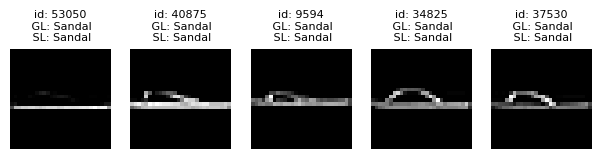

In [30]:
plot_image_issue_examples(lowinfo_issues_df, num_examples=5)

Here we can see a lot of low information images belong to the Sandal class.

cleanlab is most effective when you run this code with a good ML model. Try to produce the best ML model you can for your data (instead of the toy model from this tutorial).

In [31]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

assert set([53050, 40875, 9594, 34825, 37530]).issubset(lowinfo_issues_df.index.values.tolist())
assert set([34848, 50270, 3936, 733, 8094]).issubset(dark_issues_df.index.values.tolist())
assert set([47824, 3370, 3952, 37119]).issubset(near_duplicate_issues_df.index.values.tolist())
assert set([38093, 22628, 44031, 25316, 40329]).issubset(outlier_issues_df.index.values.tolist())
assert set([45561, 11262, 54078, 53564]).issubset(label_issues_df.index.values.tolist())